#### Une entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).

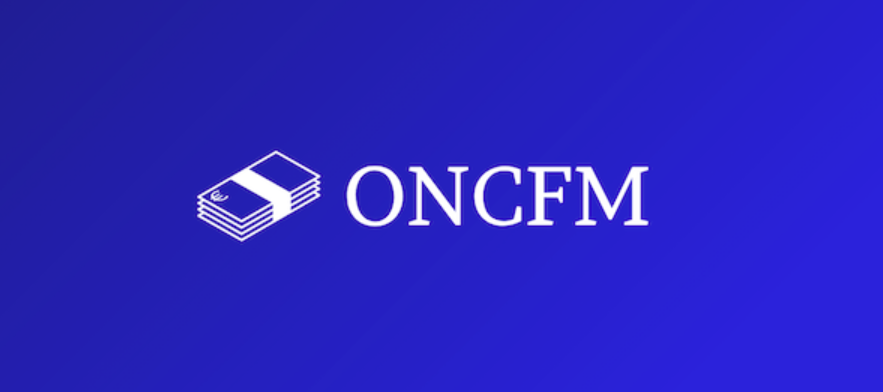

# Sommaire :


- <a href="#C1"> 1- Objectif</a>
- <a href="#C2"> 2- Importations des librairies</a>
- <a href="#C3"> 3- Exploration des données</a>
- <a href="#C4"> 4- Traitement des valeurs manquantes</a>
  - <a href="#C5">  4-1- Régression linéaire multiple</a>
  - <a href="#C6">  4-2- Evaluation du modèle de régression linéaire multiple</a>
  - <a href="#C7">  4-3- Tests sur la régression linéaire multiple</a>
  - <a href="#C8">  4-4- Imputation des valeurs manquantes</a>
- <a href="#C9"> 5- Analyse exploratoire des données</a>
  - <a href="#C10"> 5-1- Distribution des billets en fonction de leur nature</a>
  - <a href="#C11"> 5-2- Distribution des billets statiquement</a>
  - <a href="#C12"> 5-3- Séparation des faux billets et vrai billets</a>
- <a href="#C13"> 6- Analyse des composantes principales "ACP"</a>
- <a href="#C14"> 7- Algorithme de reconnaissance des faux billets </a>
  - <a href="#C15"> 7-1- La régression logistique </a>
   - <a href="#C16"> 7-1-1- Développement du modèle "Régression Logistique" et prédiction </a>
   - <a href="#C17"> 7-1-2- Evaluation du modèle de regression logistique </a>
        - <a href="#C18"> a- La matrice de confusion </a>
        - <a href="#C19"> b- Courbe ROC  </a>
   - <a href="#C20"> 7-1-3- Application du modèle aux données test "billet_production.csv"  </a>
  - <a href="#C21"> 7-2- Kmeans </a>
   - <a href="#C22"> 7-2-1- Implémentation du Kmeans </a>
   - <a href="#C23"> 7-2-2- Evaluation du modèle du Kmeans </a>
   - <a href="#C24"> 7-2-3- Application du modèle aux données test "billet_production.csv </a>
  - <a href="#C25"> 7-3- Algorithme de detection des faux billets </a>

# <a name="C1"> 1- Objectif </a>


> Mettre en place des méthodes d’identification des contrefaçons des billets en euros. 
>
> Mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets à partir de leurs caractéristiques géométriques.

# <a name="C2"> 2- Importations des librairies </a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn import cluster, metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
# Pour le K-mean:
from sklearn import decomposition
from sklearn.cluster import KMeans
# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression
# test 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
# Test Anova
from statsmodels.stats.weightstats import ztest
import scipy
from scipy.stats import norm
#ignorer warning
import warnings
warnings.filterwarnings("ignore")

# <a name="C3"> 3- Exploration des données </a>

### Importation des données

In [2]:
billets = pd.read_csv("billets.csv", delimiter=';')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### Dimensions géométriques

> **is_genuine** : la nature du billet: True pour un vrai billet et False pour un faux billet;

> **length** : la longueur du billet (en mm) ;

> **height_left** : la hauteur du billet (mesurée sur le côté gauche, en mm) ;

> **height_right** : la hauteur du billet (mesurée sur le côté droit, en mm) ;

> **margin_up** : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;

> **margin_low** : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;

> **diagonal** : la diagonale du billet (en mm).

### Les doublons 

In [3]:
# Rien à signaler 
billets.duplicated().sum()

0

### Les valeurs manquantes

> Nous avons **37 valeurs manquantes** sur la variable **margin_low**.

In [4]:
 billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

### Résumé des données brutes

In [5]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# <a name="C4"> 4- Traitement des valeurs manquantes </a>

> On va faire une imputation par regression linéaire multiple:

> On va estimer un modèle de régression avec plusieurs variables explicatives "indépendantes" et une variable dépendante qui est celle qui contient les valeurs manquantes margin_low ou Y.

## <a name="C5"> 4-1- Régression linéaire multiple </a>

In [7]:
# Suppression les données manquantes :
df_train = billets.dropna()
#Création d'un dataset comprenant les valeurs manquantes sur la variable margin_low
VM_data = billets[billets.isnull().any(axis=1)]

# Creation de X_train et Y_train:
# x_train: comprend toutes les variables indépendantes
# y_train: comprend la variable dépendante qui doit être prédite par ce modèle
x_train = df_train.drop("margin_low", axis=1)
y_train = df_train["margin_low"]
# x_train.shape -> (1463, 6)
# y_train.shape -> (1463,) (i.e. margin_low)
# Regression lineaire:
RL = LinearRegression()
model_reg_lin = RL.fit(x_train, y_train)

In [8]:
#statsmodels.formula.api -> ols
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 14 Jun 2023   Prob (F-statistic):          2.60e-202
Time:                        21:10:06   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

* Les erreurs standard supposent que la matrice de covariance des erreurs est correctement spécifiée.
* Le nombre de conditions est élevé, 1,94e+05. Cela peut indiquer qu'il y a une forte multicolinéarité ou d'autres problèmes numériques.

## <a name="C6"> 4-2- Evaluation du modèle de régression linéaire multiple </a>

> **Le coefficient de détermination**

Le **R² ajusté** est égal à 0.47,c’est le pourcentage de variation de la variable dépendante qui est expliqué par un modèle linéaire corrigé par le nombre de degrè de liberté.

Ce dernier ne permet pas de savoir si le modèle est statistiquement significatif, c'est ici qu'intervient le test de significativité glogale de Fisher.

> **Test de significativité globale de Fisher**

La formulation du test d'hypothèse qui permet d'évaluer globalement le modèle est la suivante :
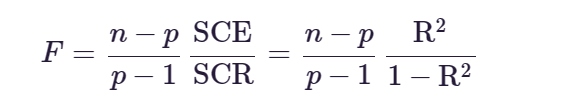
Le test de significativité permet de tester l'homogénéité des variables du modèle. Ce test permet de vérifier si le modèle, pris dans sa globalité, est pertinent. L'hypothèse nulle correspond à la situation où aucune des variables exogènes (variables explicatives) n'amène de l'information utile dans l'information de la variable endogène (variable à expliquer). Dans ce cas, le modèle ne sert à rien. Le test s'écrit :

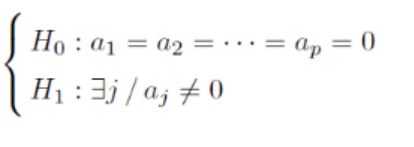

**La règle de décision au seuil de 5% est la suivante :**

>  Si **Prob(F-Statistic) > 0,05** alors on accepte l'hypothèse H0 : **le modèle n'est pas significatif**.

>  Si **Prob(F-Statistic) < 0,05** alors on ne saurait accepter l'hypothèse H0 : **Le modèle est significatif**

> Prob(F-Statistic): Ici, elle est très faible et inférieure au seuil alpha 5 % , **on rejet l'hypothèse nulle**.
> **Notre modèle est significatif**.

## <a name="C7"> 4-3- Tests sur la régression linéaire multiple </a>

#### 1. Normalité de la distribution des résidus : 

> L'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de **Prob(Omnibus)** doit être proche de 1. 

> **Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée.** 

> **Prob(Jacque-Bera)** est redondant avec Prob(Omnibus), une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi Normale. Pour lever le doute on effectue un test d'Aderson-Darling qui nous indique que les résidus suivent une distribution Normale.

In [9]:
# La moyenne des residus:
reg_multi.resid.mean()

8.869885155971777e-14

##### Test de Shapiro-Wilk

In [10]:
# la normalité des résidus 
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

> **Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05)**.

##### Test d'Aderson-Darling

La p-value du test d'Aderson-Darling: 5.114137678791534e-12


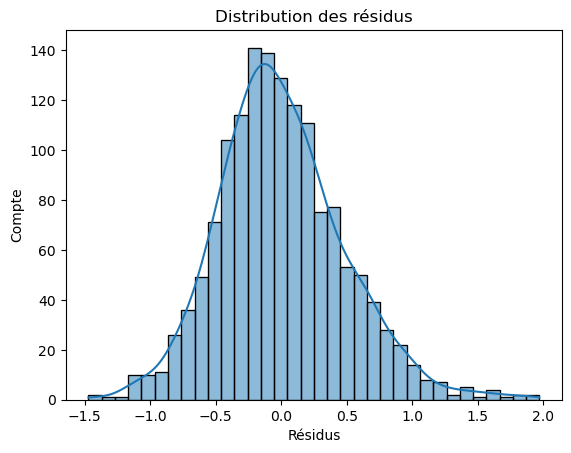

In [11]:
# Normalité des résidus
# Creation d'une colonne contenant les residus:
df_train["margin_low_pred"] = reg_multi.predict(x_train)
df_train["residual"] = df_train["margin_low"] - df_train["margin_low_pred"]

# Normalite:
print("La p-value du test d'Aderson-Darling:", normal_ad(df_train["residual"])[1])

# Graphique:
sns.histplot(df_train["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

> **La p-value <0.05 => les résidus suivent une loi normale**

#### 2.Homoscédasticité : 

> Les variances des résidus doivent être constantes. 

> Les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. 

> Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de White qui est en fait un cas particulier du Breusch-Pagan.

> Il existe aussi le test de Goldfeld et Quandt qui n'est plus vraiment utilisé.

{'Test Statistic': 109.8601519689273, 'p-value': 2.082824498747393e-14, 'F-Statistic': 5.853731207816568, 'F-Test p-value': 4.97486509210616e-15}


Text(0.5, 1.0, 'Homoscédasticité')

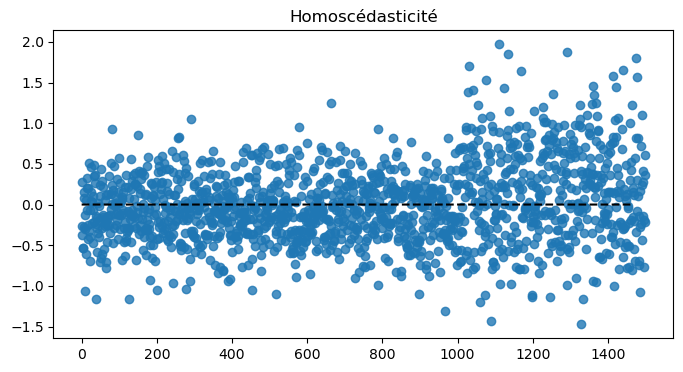

In [12]:
# Homoscedasticite:
# le test de White est un test statistique qui teste si la variance des erreurs d'un modèle de régression est constante 
# (homoscédasticité).
white_test = het_white(reg_multi.resid, reg_multi.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=df_train.index, y=df_train["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(df_train.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

> **L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 %**.

#### 3. Non-autocorrélation : 

L'autocorrélation est la corrélation des erreurs (résidus) dans le temps. 

* Durbin-Watson < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 
* 1.5 < Durbin-Watson < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. 
* Durbin-Watson > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite. 

> Ici, il est de **1.893**, il n'y a donc pas d'autocorrélation, l'hypothèse est satisfaite.

#### 4. Multicollinéarité : 

> On suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. 

> Le **cond. No.** est élevée il semble qu'il y ai un problème de multicollinéarité. 

> Le Variance Inflation Factor **VIF** (facteur d'influence de la variance) indique effectivment une forte multicolinéarité.

In [13]:
# multicolinéaritéfrom statsmodels.stats.outliers_influence import variance_inflation_factor
vif= pd.Series([variance_inflation_factor(df_train[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(df_train[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index=df_train[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())

VIF par features:
 diagonal        170566.670778
height_left     111895.309916
height_right    100858.864433
margin_up          261.969190
length           22708.222743
dtype: float64
VIF moyen: 81258.20741161003


#### 5.Linéarité : 

> On fait l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante. Non verifée ici.

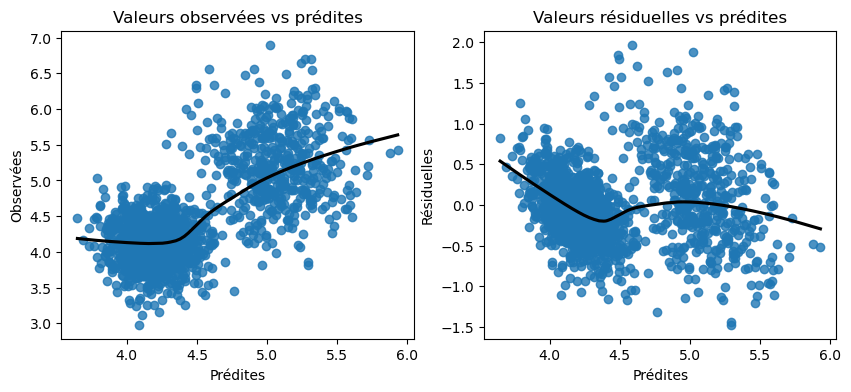

In [14]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(reg_multi, df_train["margin_low"])

**La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée.**

## <a name="C8"> 4-4- Imputation des valeurs manquantes </a>

> Nous allons faire une prediction des valeurs manquantes sur la variable **margin_low** à partie des résultats de la regression linéaire 

In [15]:
# Afficher les 37 valeurs manquantes du margin_low
#VM_data=billets[billets.isnull().any(axis=1)]
print (f"Nombre de valeurs manquantes = {len(VM_data)}")
VM_data.head(5)

Nombre de valeurs manquantes = 37


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [16]:
data=VM_data.drop(columns=['margin_low'], axis=1)
data.head(5)

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,True,171.94,103.89,103.45,3.25,112.79
99,True,171.93,104.07,104.18,3.14,113.08
151,True,172.07,103.80,104.38,3.02,112.93
197,True,171.45,103.66,103.80,3.62,113.27
241,True,171.83,104.14,104.06,3.02,112.36


In [17]:
train_df=billets.dropna()
y_train=train_df['margin_low']
y_train

0       4.52
1       3.77
2       4.40
3       3.62
4       4.04
        ... 
1495    4.42
1496    5.27
1497    5.51
1498    5.17
1499    4.63
Name: margin_low, Length: 1463, dtype: float64

In [18]:
x_train=train_df.drop(columns=['is_genuine','margin_low'], axis=1)
x_train

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...
1495,171.75,104.38,104.17,3.09,111.28
1496,172.19,104.63,104.44,3.37,110.97
1497,171.80,104.01,104.12,3.36,111.95
1498,172.06,104.28,104.06,3.46,112.25


In [19]:
RL=LinearRegression()
RL.fit(x_train, y_train)

LinearRegression()

In [20]:
x_test=VM_data.drop(columns=['is_genuine','margin_low'], axis=1)
x_test.head(5)

,diagonal,height_left,height_right,margin_up,length
72,171.94,103.89,103.45,3.25,112.79
99,171.93,104.07,104.18,3.14,113.08
151,172.07,103.80,104.38,3.02,112.93
197,171.45,103.66,103.80,3.62,113.27
241,171.83,104.14,104.06,3.02,112.36


In [21]:
y_pred=RL.predict(x_test)
y_pred

array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [22]:
data['margin_low']=y_pred
data.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.318525
99,True,171.93,104.07,104.18,3.14,113.08,4.393668
151,True,172.07,103.80,104.38,3.02,112.93,4.410457
197,True,171.45,103.66,103.80,3.62,113.27,4.319014
241,True,171.83,104.14,104.06,3.02,112.36,4.650617


In [23]:
reg_result = [train_df, data]
Billet_tf = pd.concat(reg_result)
Billet_tf

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.047570,2.93,111.21
1315,False,172.08,104.15,104.17,4.778967,3.40,112.29
1347,False,171.72,104.46,104.12,5.726993,3.61,110.31
1435,False,172.66,104.33,104.41,5.185862,3.56,111.47


In [24]:
Billet_tf.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

> **Notre data n'a plus de valeurs manquantes**

In [25]:
Billet_tf.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


# <a name="C9"> 5- Analyse exploratoire des données </a>

## <a name="C10"> 5-1- Distribution des billets en fonction de leur nature </a>

### Pie Chart

> Nous avons ici **66,7%** des vrais billets et **33.3%** des faux billets.

<AxesSubplot:ylabel='is_genuine'>

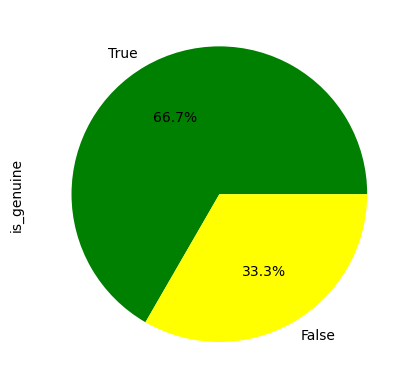

In [26]:
colors = ( "green", "yellow")
Billet_tf["is_genuine"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors )

###  Pairplot

> Le pairplot seaborn python est une fonction qui permet de tracer les relations entre les variables numériques d’un ensemble de données. Par défaut, cette fonction crée une grille de graphiques où chaque variable est partagée sur les axes x et y d’une même ligne ou colonne. Les graphiques diagonaux montrent la distribution marginale de chaque variable.

> Le pairplot seaborn python offre plusieurs paramètres pour personnaliser le type et l’aspect des graphiques. Par exemple, on peut utiliser le paramètre hue pour colorer les points selon une variable catégorielle, le paramètre kind pour choisir le type de graphique bivarié (scatter, kde, hist, reg), le paramètre diag_kind pour choisir le type de graphique univarié (auto, hist, kde, None), ou le paramètre corner pour ne tracer que la moitié inférieure de la grille.

Source : https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166

> Cette figure montre la liaison entre deux variables, nous avons ici un nuage des points qui montre la relation entre une variable en abscisse et une variable en ordonée.

> Par exemple le premier graphique montre le nuage de points de height_left par rapport à diagonal.

> On obsèrve qu'il y a une corrélation fortement négative entre _lenght_ et "_margin_up , margin_low, height_right, height_left_". Et une corrélation positive entre height_left et "margin_up, margin_low et height_right", qui sera confirmé dans la matrice de corrélation.

> D'après les histogrammes et par rapport aux  variables "is_genuine" et "lenght", on remarque une séparation relativement visible entre les deux classes "False" et "True". On peut confirmer cela en regardant les diagrammes de type scatter ou on peut facilement distinguer des clusters visiblement séparés.

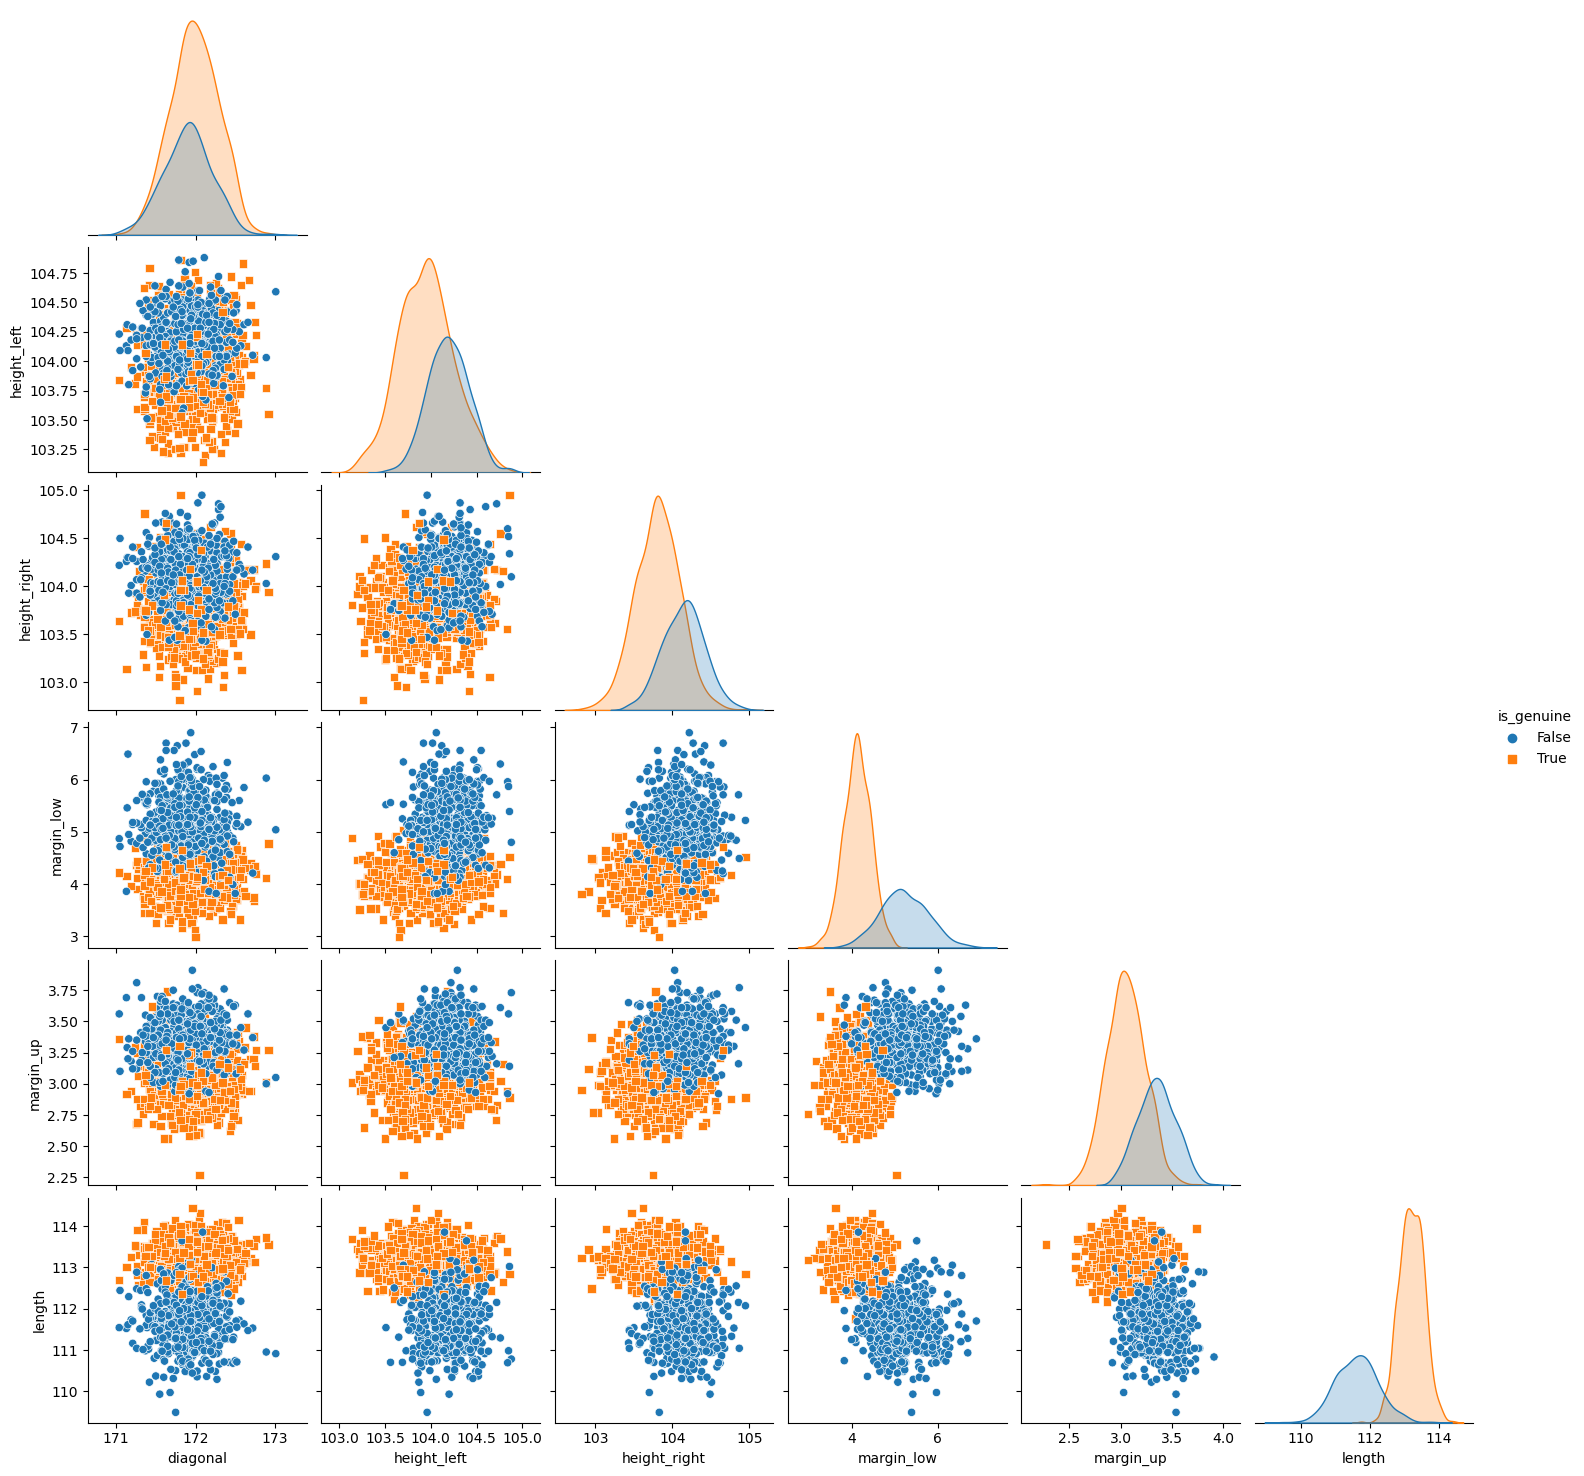

In [27]:
sns.pairplot(Billet_tf,hue='is_genuine',corner=True,markers=["o", "s"])
plt.show()

### Corrélation entre les différentes variables

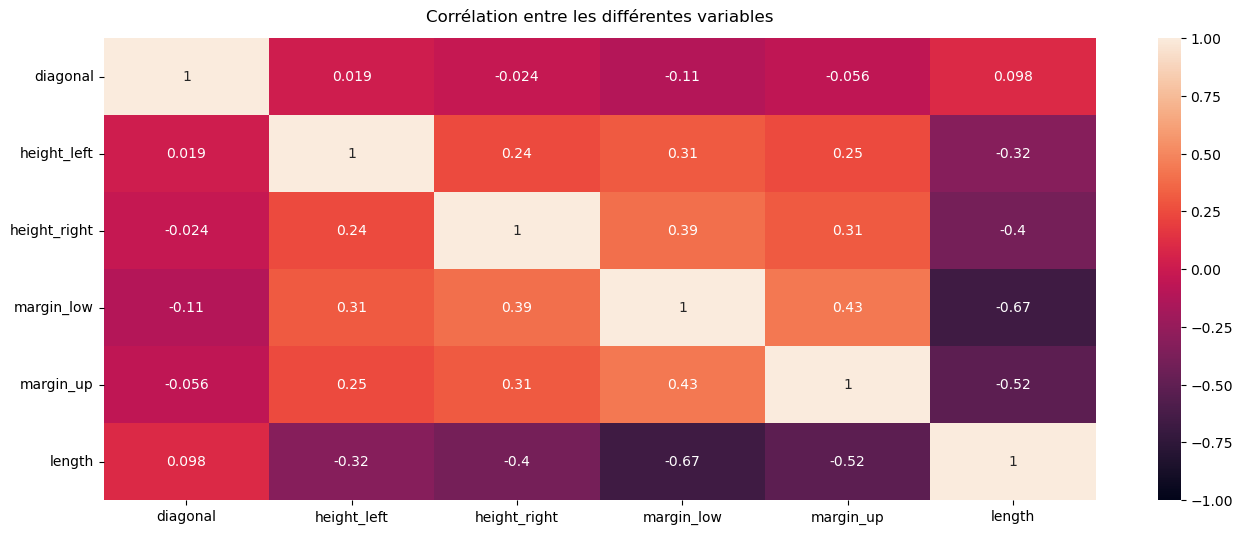

In [28]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(Billet_tf.drop(columns=['is_genuine'], axis=1).corr(),vmin=-1, vmax=1, annot=True)
heatmap.set_title('Corrélation entre les différentes variables', fontdict={'fontsize':12}, pad=12); 

## <a name="C11"> 5-2- Distribution des billets statiquement </a>

On va montrer ici la distribution des billets à l'aide de: 

> **Skewness (1)** est une mesure de l'asymétrie d'une distribution. Une distribution est asymétrique lorsque ses côtés gauche et droit ne sont pas des images miroir. 
Une distribution peut avoir une asymétrie droite (ou positive), gauche (ou négative) ou nulle. Une distribution asymétrique à droite est plus longue du côté droit de son pic, et une distribution asymétrique à gauche est plus longue du côté gauche de son pic.



> **kurtosis (2)**: 
Le kurtosis est une mesure de l’acuité et de l’aplatissement d’une distribution d’une variable aléatoire réelle. Il indique à quel point la distribution est pointue ou plate par rapport à une distribution normale. Il existe deux types de kurtosis: 

> Le kurtosis non normalisé (ou coefficient d’aplatissement) et le kurtosis normalisé (ou excès d’aplatissement). Le kurtosis non normalisé est le moment d’ordre quatre de la variable centrée réduite. 

> Le kurtosis normalisé est le kurtosis non normalisé moins 3. Le kurtosis normalisé est plus facile à manipuler lorsqu’il s’agit de calculer celui de la somme de variables indépendantes. Le kurtosis normalisé peut prendre des valeurs positives, négatives ou nulles. 

* _Une valeur nulle signifie que la distribution a le même aplatissement qu’une distribution normale._

* _Une valeur positive signifie que la distribution est plus pointue et a des queues plus épaisses qu’une distribution normale. Cela implique qu’il y a plus de probabilité de trouver des valeurs extrêmes ou des outliers._ 
* _Une valeur négative signifie que la distribution est plus plate et a des queues plus fines qu’une distribution normale. Cela implique qu’il y a moins de probabilité de trouver des valeurs extrêmes ou des outliers._



> **Kstest (3)**: le kstest est un test statistique qui permet de comparer la distribution d’un échantillon de données à une distribution théorique. Le nom kstest vient de **Kolmogorov-Smirnov** test, du nom des deux mathématiciens qui l’ont proposé. Le kstest mesure la distance maximale entre les fonctions de répartition empirique et théorique des données, et calcule une valeur-p qui indique la probabilité d’observer une telle distance si les données suivaient la distribution théorique. Plus la valeur-p est petite, plus le test rejette l’hypothèse que les données suivent la distribution théorique. Le kstest peut être utilisé pour tester la normalité des données, en comparant les données à une loi normale avec les mêmes moyenne et écart-type que l’échantillon. En python, le kstest peut être réalisé avec la fonction kstest du module scipy.stats.

(1) source : https://www.scribbr.com/statistics/skewness/

(2) source: https://www.scribbr.com/statistics/kurtosis/

(3) source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

Diagonal


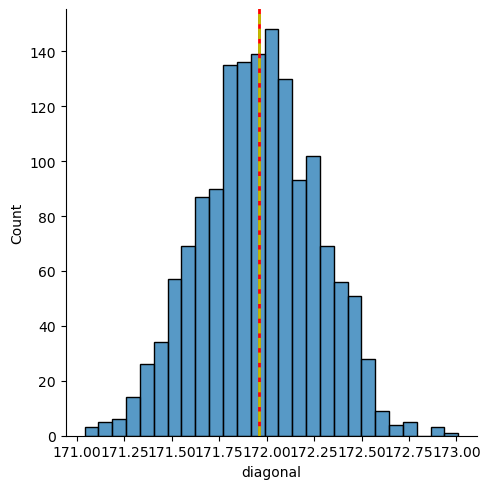

Skewness:  -0.03327338562609546
Kurtosis:  -0.12886436386674305
KstestResult(statistic=0.04733333333333333, pvalue=0.132945563169621)
Height_left


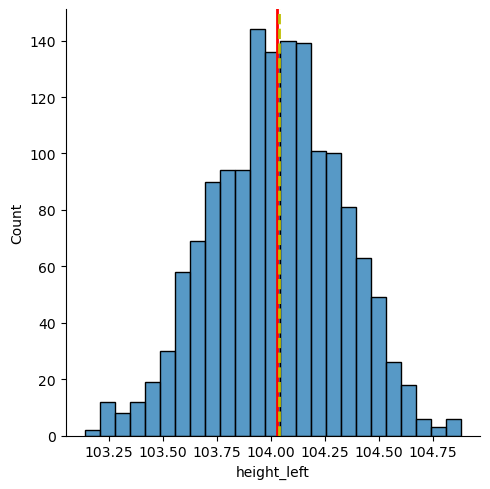

Skewness:  -0.0920284800066563
Kurtosis:  -0.19861842156870946
KstestResult(statistic=0.04066666666666666, pvalue=0.2691017825080854)
Height_right


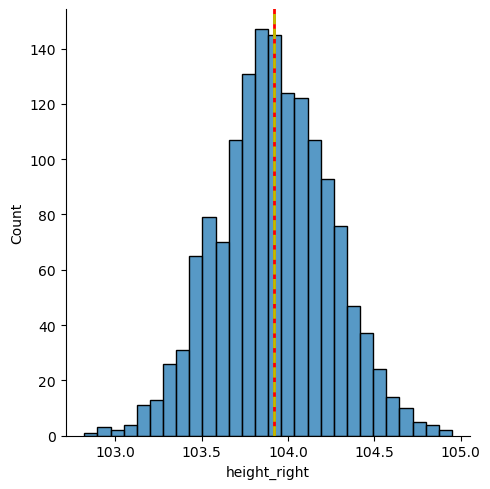

Skewness:  -0.00032721955634103526
Kurtosis:  -0.03113831813816237
KstestResult(statistic=0.023666666666666666, pvalue=0.8843181184559203)
Margin_low


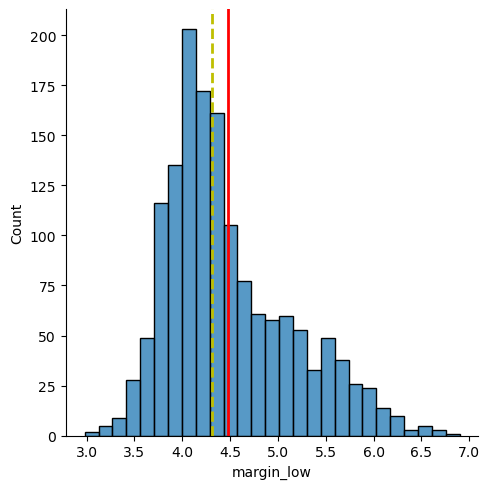

Skewness:  0.8697706246225955
Kurtosis:  0.2499175401706495
KstestResult(statistic=0.13666666666666666, pvalue=3.252501356458498e-10)
Margin_up


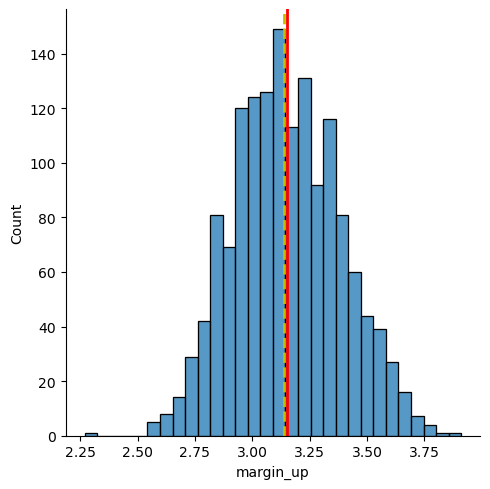

Skewness:  0.14579184782536242
Kurtosis:  -0.248256984444303
KstestResult(statistic=0.044, pvalue=0.19178172870967158)
Length


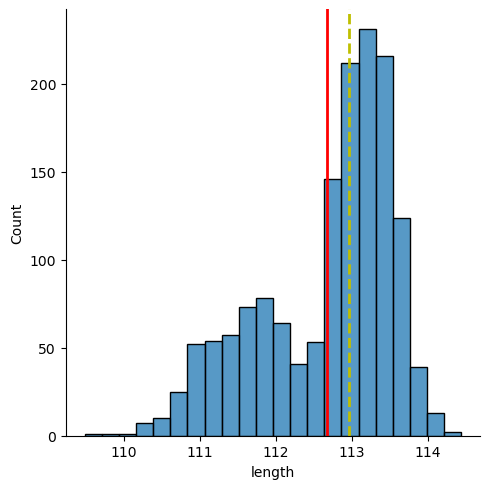

Skewness:  -0.8151403548537487
Kurtosis:  -0.2833883960922541
KstestResult(statistic=0.147, pvalue=9.38837332651624e-12)


In [29]:
import scipy as st
from scipy.stats import ks_2samp
def distrib_normalize(i):
  
  print(i.capitalize())
  _ = sns.displot(Billet_tf[i])
  _ = plt.axvline(x=Billet_tf[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=Billet_tf[i].median(), label='Médiane', linestyle='--', color='y', linewidth=2)
  _ = plt.show()
  print('Skewness: ', str(st.stats.skew(Billet_tf[i])))
  print('Kurtosis: ', str(st.stats.kurtosis(Billet_tf[i])))
  print(str(ks_2samp(Billet_tf[i],list(np.random.normal(np.mean(Billet_tf[i]), np.std(Billet_tf[i]), 1000)))))

cols = Billet_tf[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)

#### Skewness interprétation: 

* **Diagonal (-0,33)**:

La distribution est asymétrique à gauche parce qu'elle est plus longue sur le côté gauche de son sommet. La longue queue à gauche représente la petite proportion des billets qui ont un diagonale très faibles que la moyenne (171.95).

* **Margin-up (0,14)**: 

La distribution est asymétrique parce qu'elle est plus longue du côté droit de son sommet. Il y a une longue queue à droite, ce qui signifie que toutes les billets, il y a des billets où la marge supérieur est plus élevé que la moyenne (3.15).

* **Height-right** (-0,0003):

La distribution est asymétrique à gauche parce qu'elle est plus longue sur le côté gauche de son sommet. La longue queue à gauche représente la petite proportion des billets qui ont une hauteur mesurée à droite faibles que la moyenne (103.92).

* **Height-left (-0,09)**:

La distribution est asymétrique à gauche parce qu'elle est plus longue sur le côté gauche de son sommet. La longue queue à gauche représente la petite proportion des billets qui ont une hauteur mesurée à gauche très faibles que la moyenne (104.02).

* **Margin-low (0,86)**:

La distribution est asymétrique parce qu'elle est plus longue du côté droit de son sommet. Il y a une longue queue à droite, ce qui signifie que toutes les billets, il y a des billets où la marge inférieure est beaucoup plus élevé que la moyenne (4.48).

* **Lenght (-0,81)**:

La distribution est asymétrique à gauche parce qu'elle est plus longue sur le côté gauche de son sommet. La longue queue à gauche représente la petite proportion des billets qui ont une longueur très faibles que la moyenne (112.6).

#### Kurtosis interprétation

* **'diagonal', 'height_left', 'height_right','margin_up', 'length'**: 
Ces variables ont un kurtosis normalisé négatif, donc se sont des distributions uniforme, car elles sont très plate et a peu de variation autour de la moyenne

* **Margin_low**: 
Cette variavle a un kurtosis normalisé positif donc s'est une distribution binomiale , car elle est très pointue et a beaucoup de variation autour de la moyenne.

#### Kstest interprétation:

* **Diagonal, height-right, height-left et margin-up**:

> Ce résultat indique que la distance maximale entre les fonctions de répartition empirique et normale est de ("Diagonal:0.026","Height_right:0.042","Height_right:0.029","Margin_up:0.052") et que la probabilité d’observer une telle distance si les données étaient normales est de ("Diagonal:0.805","Height_right:0.235","Height_right:0.686", "Margin_up:0.076"). Comme la valeur-p est supérieure à 0.05, on ne peut pas rejeter l’hypothèse nulle que les données sont normales.


* **Margin-low et lenght**:

> Ce résultat indique que la distance maximale entre les fonctions de répartition empirique et normale est de ("Margin_low:0.148","Lenght:0.146") et que la probabilité d’observer une telle distance si les données étaient normales est de ("Margin_low:5.17e-12","Lenght:1.056e-11"). Comme la valeur-p est inférieur à 0.05, on peut rejeter l’hypothèse nulle que les données ne sont pas distribuées selon la loi normale.

## <a name="C12"> 5-3- Séparation des faux billets et vrai billets </a>

In [30]:
# séparation de notre dataset
faux_billets= Billet_tf.loc[Billet_tf['is_genuine'] ==False]
vrai_billets= Billet_tf.loc[Billet_tf['is_genuine'] ==True]
print(vrai_billets.shape,faux_billets.shape)

(1000, 7) (500, 7)


In [31]:
vrai_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,171.987080,103.949130,103.80865,4.118174,3.05213,113.202430
std,0.300441,0.300231,0.29157,0.317575,0.18634,0.359552
min,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,171.790000,103.740000,103.61000,3.910000,2.93000,112.950000
50%,171.990000,103.950000,103.81000,4.120000,3.05000,113.205000
75%,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [32]:
faux_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,171.901160,104.190340,104.143620,5.214079,3.350160,111.630640
std,0.306861,0.223758,0.270878,0.550363,0.180498,0.615543
min,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,171.910000,104.180000,104.160000,5.180000,3.350000,111.630000
75%,172.092500,104.332500,104.320000,5.590000,3.472500,112.030000
max,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


### Test ANOVA

Nous vérifions ici si les différences de moyennes des caractéristiques de nos billets sont significatives

> H0: Les moyennes des vrais billets et celles des faux billets sont égales
>
> H1: Les moyennes ne sont pas égales.

In [33]:
# Variable quantitative
x =( "diagonal","height_left","height_right","margin_low","margin_up","length")
# Variable qualitative
y = "is_genuine"
for i in x:
    samplei = Billet_tf[i][Billet_tf[y]]
    sample1 = Billet_tf[i][~Billet_tf[y]]

    F_Statistic, pvalue = scipy.stats.f_oneway(samplei, sample1)
    print("F_Statistic = {}, pvalue = {}".format(
        round(F_Statistic, 2),
        round(pvalue, 2)))
    if pvalue < 0.05:
        print("On rejette H0.\nLes vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= {} à un niveau de confiance de 95%.".format(i))
       
    else:
        print("On ne rejette pas H0: Les moyennes sont identiques pour la variable x= {} à un niveau de confiance de 95%.".format(i))
    

F_Statistic = 26.87, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= diagonal à un niveau de confiance de 95%.
F_Statistic = 252.56, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= height_left à un niveau de confiance de 95%.
F_Statistic = 460.97, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= height_right à un niveau de confiance de 95%.
F_Statistic = 2380.72, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= margin_low à un niveau de confiance de 95%.
F_Statistic = 870.58, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que les faux  billets pour la variable x= margin_up à un niveau de confiance de 95%.
F_Statistic = 3876.65, pvalue = 0.0
On rejette H0.
Les vrais billets n'ont pas la même moyenne que l

**Les moyennes des variables explicatives sont statistiquement différentes selon la nature du billet.**

# <a name="C13"> 6- Analyse des composantes principales "ACP" </a>

### Normalisation des données

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [35]:
X = Billet_tf[["diagonal","height_left","height_right","margin_low","margin_up","length"]].values
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

scree: [43.29 16.96 13.03 11.82  9.6 ]
Scree_cum: [43. 60. 73. 85. 95.]


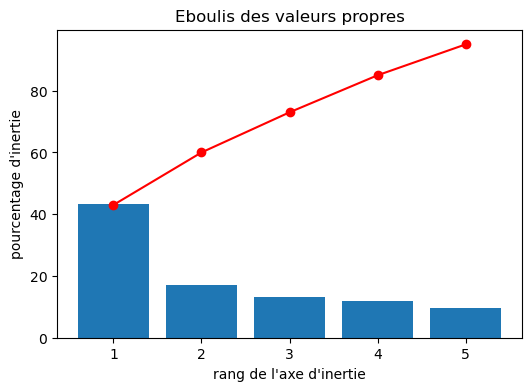

In [36]:
# Nous allons travailler que sur les 5 premières composantes :
n_components = 5

# Calcul des composantes principales (On instancie notre ACP :)
pca = PCA(n_components=n_components)
# On l'entraine sur les données scalées :
pca.fit(X_scaled)
#Intéressons nous maintenant à la variance captée par chaque nouvelle composante. 
#Grace à scikit-learn on peut utiliser l'attribut explained_variance_ratio_ :
#Enregistrons cela dans une variable :
scree = (pca.explained_variance_ratio_*100).round(2)
print("scree:",scree)
scree_cum = scree.cumsum().round()
print("Scree_cum:",scree_cum)
# Définisons ensuite une variable avec la liste de nos composantes :
x_list = range(1, n_components+1)

#On peut enfin l'afficher de façon graphique :
plt.figure(figsize=(6,4))
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

#### Observations
On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.

Nous avons dans notre cas l'inertie totale répartie inéquitablement sur 6 axes

* Axe 1 : 43.29 % de l'inertie totale
* Axe 2 : 16.96 % de l'inertie totale
* Axe 3 : 13.03 % de l'inertie totale
* Axe 4 : 11.82 % de l'inertie totale
* Axe 5 : 9.6 % de l'inertie totale

On voit ici que plus de 80% de la variance est comprise dans les 4 premières composantes, et plus de 90% dans les 5 premières.

In [37]:
#La formule de ce calcul nous est donnée par l'attribut components_. Cette variable est généralement nommée pcs :
pcs = pca.components_
# Affichons la même chose mais version pandas :
pcs = pd.DataFrame(pcs)

In [38]:
# choix du nombre de composantes à calculer
n_comp = 5
# selection des colonnes à prendre en compte dans l'ACP
features = Billet_tf[["diagonal","height_left","height_right","margin_low","margin_up","length"]].columns
# Cercle des corrélations

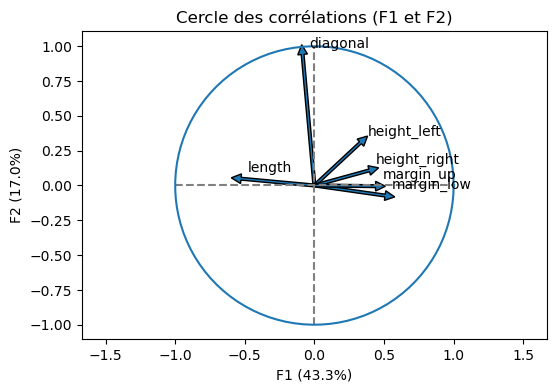

In [39]:
# Définissons nos axes x et y. Nous allons utiliser les 2 premières composantes. 
# Comme - en code - on commence à compter à partir de 0, cela nous donne :
x_y = (0,1)
x_y
#On peut en faire une fonction :
def correlation_graph(pca, x_y, features) : 
    """
    Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(6, 4))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)
# cercle des corrélations (F1 et F2)
correlation_graph(pca, (0,1), features)

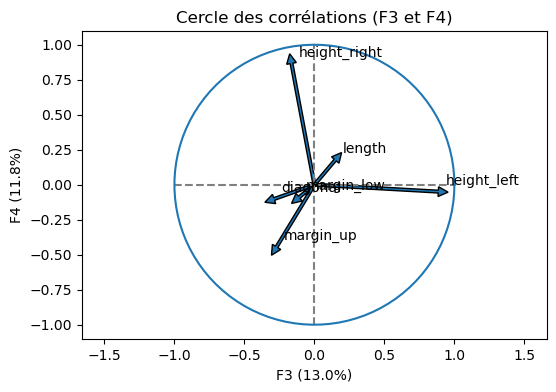

In [40]:
#Essayons pour F3 et F4 :
correlation_graph(pca, (2,3), features)

In [41]:
# création de la matrice de corrélation
t=pca.components_[:]
df_corr_comp = pd.DataFrame(t,index = ['F1', 'F2', 'F3','F4','F5'],\
                            columns=Billet_tf[["diagonal","height_left","height_right","margin_low","margin_up","length"]]\
                            .columns)
df_corr_comp.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
F1,-0.084698,0.330634,0.393555,0.507693,0.439415,-0.527052
F2,0.941304,0.307528,0.108332,-0.072440,-0.004954,0.048636
F3,-0.287843,0.885049,-0.163563,-0.109046,-0.270112,0.149099
F4,-0.101961,-0.049244,0.866562,-0.089271,-0.444047,0.176360
F5,-0.115992,0.101652,0.235998,-0.564088,0.711988,0.308863


### OBSERVATIONS

**F1 :** 

- Variables corrélées positivement: 
    Margin_low est fortement corrélé (0.50)
- Variables corrélées négativement : 
  La longueur est fortement corrélé (- 0,53)
  
- On peut dire que l'axe F1 représente le margin_low

**F2 :**

- variables corrélées positivement : 

  Le diagonale est très fortement corrélé (0.94)
  
- On peut dire que l'axe F2 représente le diagonale



**F3 :**

- variables corrélées positivement : le  height left est très fortement corrélé (0,89)

**F4 :**

- variables corrélées positivement : Le height_right est fortement corrélé (0.87)
- variables corrélées négativement : Le margin_up est corrélé (- 0.44)

# <a name="C14"> 7- Algorithme de reconnaissance des faux billets </a>

L'objectif de ce projet est construire des algorithmes capables de faire des classifications automatiques en vue de partitionner les données en vrais ou faux billets. Pour ce faire, nous allons construire deux algorithmes: 

* Le premier basé sur la regression logistique
* Le second sur le k-mean

## <a name="C15"> 7-1- La régression logistique </a>

Le principe du modèle de la régression logistique est d'expliquer la survenance ou non d'un événementdans notre cas faux billet ou vrai billet par le niveau de variables explicatives quantitatives (notées X). 

Le but est de construire un algorithme de regression logistique qui permet de classifier les billets en vrai ou faux. Nous allons segmenter nos données en données d'entrainement et données de test puis nous évaluerons notre modèle sur les données de test.

Nous allons d'abord implementer la regression logistiques avec la librairie statmodel qui nous permet d'avoir un résumé des performance de la regression ainsi que les principaux paramètres.

In [42]:
# variable binaire
y_billet = Billet_tf["is_genuine"]
print(y_billet.value_counts())

True     1000
False     500
Name: is_genuine, dtype: int64


In [43]:
# dataset de variables explicatives
x_billet=Billet_tf.drop(columns=['is_genuine'], axis=1)
# ajouter une constance au model
x_billet = sm.tools.add_constant(x_billet)
x_billet.head(5)
# x_billet.shape --> (1500, 7)

,const,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [44]:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

# Regression logistique:
reg_log = Logit(endog=y_billet,exog=x_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.028228
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:                  0.9557
Time:                        21:10:18   Log-Likelihood:                -42.342
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -204.5582    241.768     -0.846      0.398    -678.415     269.299
diagonal         0.068

* **En globalité le modèle est significatif (la p_value est inférieur à 5%).**

* **Il y a deux variables qui ne sont pas significatives dans le modèle(la diagonale, heigth_left), mais avec le R2 ajusté très elevé, nous pouvons les garder dans le modèle.**

Tout d'abord on va exclure les variables significatives pour voir si les statistiques et paramètres du modèle s'améliorent.

### Modèle excluant les variables non significatives

In [45]:
x2_billet=Billet_tf.drop(columns=['is_genuine','diagonal','height_left'], axis=1)
# Regression logistique:
reg_log2 = Logit(endog=y_billet,exog=x2_billet)

# Calculs:
res_log2 = reg_log2.fit()

# Resume des resultats:
print(res_log2.summary())

Optimization terminated successfully.
         Current function value: 0.030986
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1496
Method:                           MLE   Df Model:                            3
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:                  0.9513
Time:                        21:10:19   Log-Likelihood:                -46.478
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_right    -5.0148      0.680     -7.376      0.000      -6.347      -3.682
margin_low      -5.868

**En excluant les deux variables 'diagonal', 'height_left', les statistiques et paramètres du modèle ne s'améliorent pas significativement. On va les garder pour la suite.**

### <a name="C16"> 7-1-1- Développement du modèle "Régression Logistique" et prédiction </a>

In [46]:
# Valeurs caractéristiques
x = Billet_tf [['diagonal','height_left','height_right','margin_low','margin_up','length']]
# Valeur ciblée
y = Billet_tf["is_genuine"]

test_size float ou int,
Si flottant, doit être compris entre 0,0 et 1,0 et représenter la proportion du jeu de données à inclure dans le fractionnement de test. Si int, représente le nombre absolu d’échantillons d’essai. Si Aucun, la valeur est définie sur le Complément de la taille du train. Si est également Aucun, il sera être réglé sur 0,25.train_size

In [47]:
# Séparation du dataseet en données d'entrainement et données de test
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1) 
print(y_test.shape)
print(y_train.shape)

(300,)
(1200,)


> **Metrics.accuracy_score** est une fonction qui calcule le score de précision de la classification. C’est le rapport entre le nombre d’échantillons correctement classés et le nombre total d’échantillons. Le meilleur score est 1 lorsque tous les échantillons sont correctement classés.

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
reg_logit = linear_model.LogisticRegression()    
reg_logit.fit(x_train, y_train)   
y_pred = reg_logit.predict(x_test) 
   
print("Logistic Regression model accuracy(in %):",  
metrics.accuracy_score(y_test, y_pred)*100) 

Logistic Regression model accuracy(in %): 98.33333333333333


### <a name="C17"> 7-1-2- Evaluation du modèle de regression logistique </a>

On peut évaluer la qualité d'un modèle par validation croisée, et étudier un certain nombre de critères, parmi lesquels la sensibilité et la spécificité, calculées à partir de **la matrice de confusion**.

#### <a name="C18"> a- La matrice de confusion </a>

La matrice de confusion est un outil de mesure de la performance des modèles de classification à 2 classes ou plus. Dans le cas binaire (i.e. à deux classes, le cas le plus simple), la matrice de confusion est un tableau à 4 valeurs représentant les différentes combinaisons de valeurs réelles et valeurs prédites.

Cette matrice est indispensable pour définir les différentes métriques de classification telles que l’Accuracy, le F1-score ou encore l’AUC PR et l’AUC ROC.

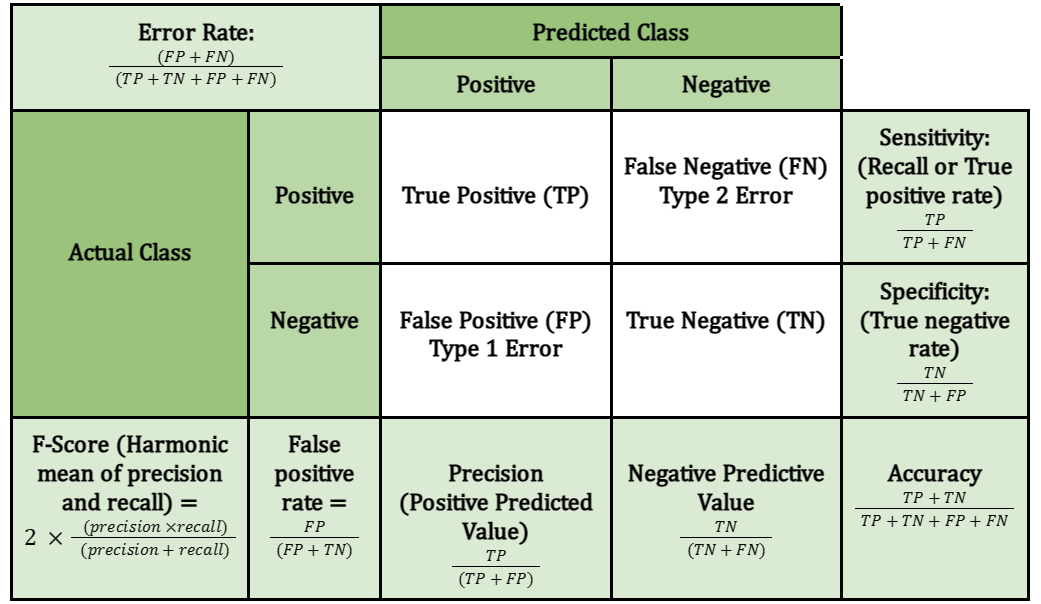

#### Les 4 cas possibles lors d’une prédiction binaire sont :

* **Vrai négatif (True Negative) :**

- La prédiction est négative et c’est la réalité.

* **Vrai positif (True Positive) :**

- La prédiction est positive et c’est la réalité.


* **Faux positif (False positive), erreur de 1ère espèce :**

- La prédiction est positive mais ce n’est pas la réalité.

* **Faux négatif (False negative), erreur de 2ème espèce :**

- La prédiction est négative mais ce n’est pas la réalité.


> **Accuracy**: Performance globale du modèle, représente le taux de prédictions qui correspondent exactement aux étiquettes de classes réelles:
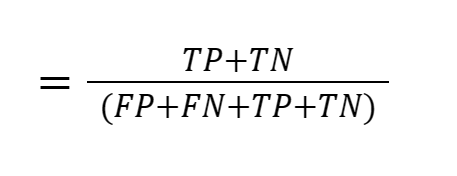

> **Precision**: la capacité d’un modèle à éviter d’étiqueter des échantillons négatifs comme positifs:
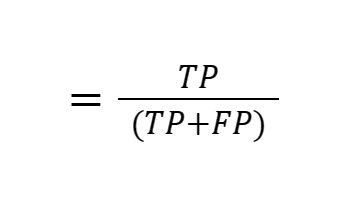

> **Recall ou Sensibilité**: Couverture des observations vraiment positives:
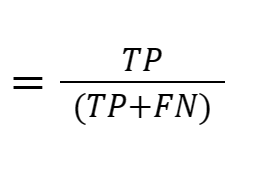

> **Spécificité**: Couverture des observations vraiment négatives:
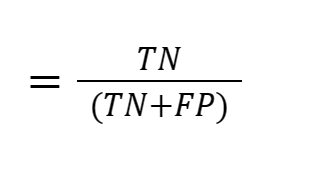

In [49]:
from sklearn.metrics import confusion_matrix
matrix_confusion = confusion_matrix(y_test, y_pred)
print(matrix_confusion)

[[ 92   4]
 [  1 203]]


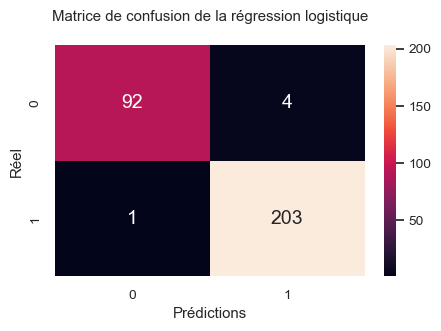

In [50]:
plt.figure(figsize=(5,3))
sns.set(font_scale=0.9) # for label size
sns.heatmap(matrix_confusion, annot=True, annot_kws={"size": 14},fmt = ".3g")
xticklabels = ["Faux","Vrai"],
yticklabels=["Faux","Vrai"]
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.title("Matrice de confusion de la régression logistique\n")
plt.show()

In [51]:
y_test.value_counts()

True     204
False     96
Name: is_genuine, dtype: int64

**The formula for the F1 score "moyenne harmonique"is:**

F1 = 2 * (precision * recall) / (precision + recall)

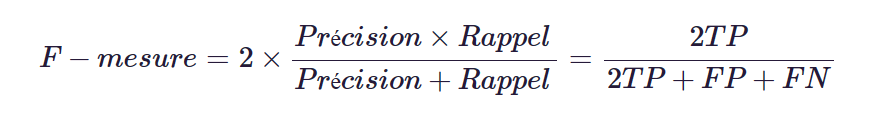

In [52]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
print("\033[0;34m Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("\033[0;31m Precision:",metrics.precision_score(y_test, y_pred))
print("\033[0;32m Recall ou Sensibilité:",metrics.recall_score(y_test, y_pred))
print("\033[0;35m Score F1:",f1_score(y_test, y_pred))

 Accuracy: 0.9833333333333333
 Precision: 0.9806763285024155
 Recall ou Sensibilité: 0.9950980392156863
 Score F1: 0.9878345498783455


**Interpretation de la matrice de confusion**

* La matrice de confusion nous donne des informations sur la performance de prediction du modèle. Sur les 96 faux billets, 92 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 95,83%.


* Les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 203 sur les 204 vrais billets de l'echantillon de test. le nombre de faux positif ou le vrais billets de banque qui ont été classifiés comme faux est de 1 le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 4.


**Interpretation des autres métriques:**

* L'accuracy est de 98% c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.3%;


* La précision est de 98,08% c'est la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;


* Le Recall (rappel) ou sensibilité est de 99,50%: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.

* Score F1 est de 98,78% indique une précision et un rappel parfaits


### _Les métriques d'évaluation de notre modèle de regression logistique sont satisfaisantes._

#### <a name="C19"> b- Courbe ROC </a>

Le terme courbe ROC signifie courbe caractéristique de fonctionnement du récepteur. Cette courbe est essentiellement une représentation graphique des performances de tout modèle de classification à tous les seuils de classification.

Il y a deux paramètres de cette courbe :

* True Positive Rate (TPR) - Signifie réel, c’est-à-dire une vraie sensibilité

* Taux de faux positifs (FPR) - Signifie pseudo, c’est-à-dire fausse sensibilité

Les deux paramètres sont appelés caractéristiques de fonctionnement et sont utilisés comme facteurs pour définir la courbe ROC.

En Python, l’efficacité du modèle est déterminée en observant l’aire sous la courbe (Area Under the Curve, AUC). Ainsi, le modèle le plus efficace a une AUC égale à 1, et le modèle le moins efficace a une AUC égale à 0,5.

Source : https://www.delftstack.com/fr/howto/python/plot-roc-curve-python/

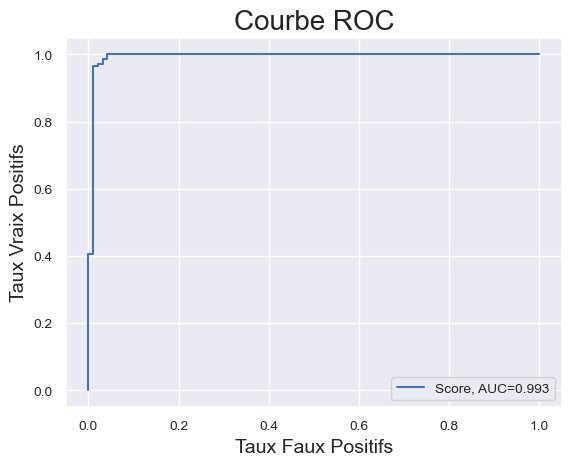

In [53]:
clf = LogisticRegression().fit(x_train, y_train)
y_pred_proba = clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
x = [0,1]
y = [0,1]
plt.plot(fpr,tpr,label="Score, AUC="+str(round(auc,3)))
plt.legend(loc=4)
plt.title('Courbe ROC', fontsize=20)
plt.ylabel('Taux Vraix Positifs', fontsize=14)
plt.xlabel('Taux Faux Positifs', fontsize=14)
plt.show()

**L'AUC est égal à 0.993 qui signifie que ce modèle une probabilité de 99,3% de distinguer correctement un faux billet d'un vrai billet.**

### <a name="C20"> 7-1-3- Application du modèle aux données test "billet_production.csv" </a>

In [54]:
test = pd.read_csv("billets_production.csv", sep=',')
print("test_shape:",test.shape)
test.head()

test_shape: (5, 7)


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [55]:
# éliminer la dernière colonne "id"
X=test.iloc[:,:-1]
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


_to get the predicted probabilities for the positive label only, we can use logistic_model.predict_proba(data)[:,1]. This will yield you the result._

In [56]:
#Utilisation du modèle de prédiction régression logistique 'lr'
probability = reg_logit.predict_proba(X.values)[:,1]
#Probabilités des billets établies 
proba = pd.Series(probability.round(3), name='value_prob')
print("Probabilité:",proba)

Probabilité: 0    0.003
1    0.001
2    0.001
3    0.922
4    1.000
Name: value_prob, dtype: float64


In [57]:
data = pd.concat([test, proba], axis=1)
data

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value_prob
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.003
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.001
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.001
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.922
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.000


**Dataframe final avec résultats des classifications:**

Pour chaque billet, l'algorithme de classification donnera la probabilité que le billet soit vrai. 

* Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai.

* Dans le cas contraire, il sera considéré comme faux.

In [58]:
#Résultats de la classification prédictive :
resultat = []
for i in data['value_prob'] >= .5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

data['resultat'] = resultat
data

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value_prob,resultat
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.003,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.001,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.001,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.922,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.000,Vrai Billet


#### Sauvegarde du modèle de la regression logistique

In [59]:
import joblib
from joblib import dump, load
dump(reg_logit, 'logit_model_detection.joblib')

['logit_model_detection.joblib']

## <a name="C21"> 7-2- Kmeans </a>

>  **k-means** est une méthode de clustering qui permet de partitionner des données en groupes homogènes selon leur distance à des centres de gravité appelés centroïdes. C’est une technique d’apprentissage non supervisé qui peut être utilisée pour analyser des données, segmenter des clients, réduire la dimensionnalité, etc.

### <a name="C22"> 7-2-1- Implémentation du Kmeans </a>

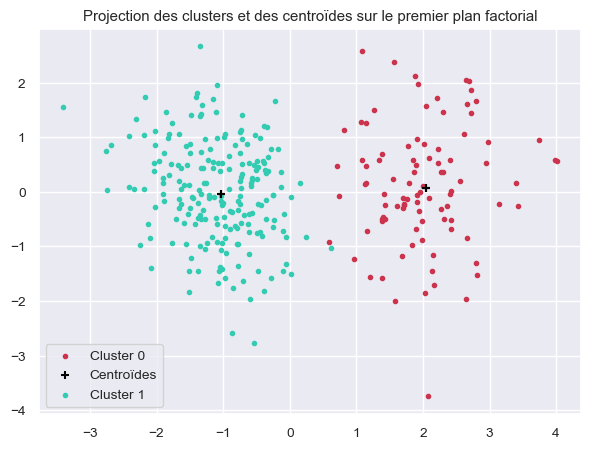

In [60]:
# Nombre des clusters
n_clusters=2
# Normaliser les données d'entraînement avec StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
# Normaliser les données de test avec le même scaler
x_test_scaled = scaler.transform(x_test)
#random_state rend les résultats reproductibles et peut être utile pour le débogage.
kmean = KMeans(n_clusters,random_state=1991)
# Entraîner le modèle sur les données d'entraînement normalisées
kmean.fit(x_train_scaled)
x_kmean_train = kmean.fit_transform(x_train_scaled)
x_kmean_test = kmean.transform(x_test_scaled)

# Prédire les labels des données de test
y_pred = kmean.predict(x_test_scaled)
# Centroides
centroids_km = kmean.cluster_centers_
# Créer un objet PCA avec 3 composantes
pca = PCA(n_components=3)

# Ajuster le PCA sur x_train_scaled
pca.fit(x_train_scaled)

# Transformer x_train_scaled et x_test_scaled
x_train_pca = pca.transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
# centroide kmean projection
centroids_km_projected = pca.transform(centroids_km)
#Graphique:
plt.figure(figsize=(7, 5))
for couleur,k in zip(['#cc334c', "#33ccb3"],[0,1]):
    plt.scatter(x_test_pca[y_pred==k,0],x_test_pca[y_pred==k,1],c=couleur,label="Cluster {}".format(k),marker='.')
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="black",label="Centroïdes", marker="+")
plt.title("Projection des clusters et des centroïdes sur le premier plan factorial")
plt.show()

**Le cluster 0 semble être celui des Faux billets et le cluster 1 celui des Vrai billets**

In [61]:
#Vérfication de la classification: Matrice de confusion:
km_matrix = pd.crosstab(y_test,y_pred)
print(km_matrix)

col_0        0    1
is_genuine         
False       93    3
True         1  203


### <a name="C23"> 7-2-2- Evaluation du modèle du Kmeans </a>

#### Matrice de confusion du Kmeans 

In [62]:
tableau = pd.crosstab(y_test,y_pred)
tableau.index = ['Cluster 0 - Faux','Cluster  1- Vrai']
tableau.columns = ['Faux_billets','Vrai_billets']
tableau

,Faux_billets,Vrai_billets
Cluster 0 - Faux,93,3
Cluster 1- Vrai,1,203


Text(0.5, 1.8906249999999947, 'Real label')

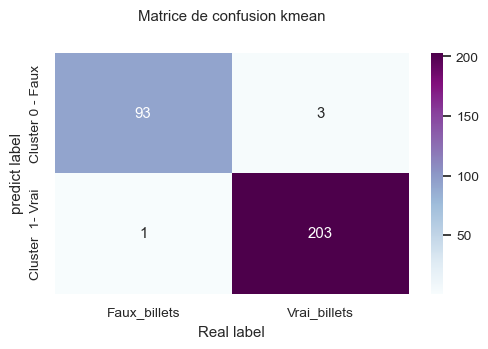

In [63]:
plt.figure(figsize=(5,3))
sns.set(font_scale=0.9) # for label size
sns.heatmap(tableau, annot=True, cmap="BuPu", fmt='g')
plt.tight_layout()
plt.title('Matrice de confusion kmean', y=1.1)
plt.ylabel('predict label')
plt.xlabel('Real label')

In [64]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
print("\033[0;34m Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("\033[0;31m Precision:",metrics.precision_score(y_test, y_pred))
print("\033[0;32m Recall ou Sensibilité:",metrics.recall_score(y_test, y_pred))
print("\033[0;33m Score F1:",f1_score(y_test, y_pred))

 Accuracy: 0.9866666666666667
 Precision: 0.9854368932038835
 Recall ou Sensibilité: 0.9950980392156863
 Score F1: 0.9902439024390244


### Interpretation de la matrice de confusion du kmean

> La matrice de confusion nous donne des informations sur la performance de prediction du modèle. Sur les 96 faux billets, 93 ont été correctement prédit(vrais négatifs) soit un taux de prediction de 96,87%.

> Les vrais positifs ou le nombre de vrais billets qui ont éte correctement classés est de 203 sur les 204 vrais billets de l'echantillon de test. le nombre de faux positif ou le vrais billets de banque qui ont été classifiés comme faux est de 1 le nombre de faux négatifs ou les faux billets de banque qui ont été classés comme vrai par le modèle est de 3.


### Interpretation des autres métriques:

* L'accuracy est de 98,67% c'est à dire que la capacité du modèle à faire de bonnes prédictions sur cet échantillon est de 98.67%;

* La précision est de 98,54% c'est la part des enregistrements réellement positifs(vrais billets) sur les enregistrements positifs prédits;

* Le Recall (rappel) ou sensibilité est de 99,51%: c'est la part des vrais billets correctement predits sur le nombre total de vrais billet ou Couverture des observations vraiment positives.

* Score F1 est de 99,02% indique une précision et un rappel parfaits

Les métriques d'évaluation de notre modèle de regression logistique sont satisfaisantes.

### <a name="C24"> 7-2-3- Application du modèle aux données test "billet_production.csv </a>

In [65]:
# Nos données d'exemple
#test = pd.read_csv("billets_production.csv", sep=',')
# X=test.iloc[:,:-1]
scaled_X = scaler.transform(X)
# Prédiction 
kmean.predict(scaled_X)
k_score =pd.Series(kmean.predict(scaled_X), name ='k_score')
km_predict_result= pd.concat([test, k_score], axis=1)
print("kmean prédiction:",kmean.predict(scaled_X))
km_predict_result

kmean prédiction: [0 0 0 1 1]


,diagonal,height_left,height_right,margin_low,margin_up,length,id,k_score
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


In [66]:
#Résultats de la classification prédictive :
resultat = []
for i in km_predict_result['k_score']:
    if i==0 :
        resultat.append('Faux Billet')
    else :
        resultat.append('Vrai Billet')

km_predict_result['resultat'] = resultat
km_predict_result

,diagonal,height_left,height_right,margin_low,margin_up,length,id,k_score,resultat
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1,Vrai Billet


#### Sauvegarde le modèle du kmean

In [67]:
dump(x_kmean_train , 'kmean_model_detection.joblib')

['kmean_model_detection.joblib']

## <a name="C25"> 7-3- Algorithme de detection des faux billets </a>

In [68]:
def test_csv_file (csv_to_test) :
    #Données de test ou fichier à évaluer
    Billet_test_df = pd.read_csv(csv_to_test)
    x_test = Billet_test_df [['diagonal','height_left','height_right','margin_low','margin_up','length']]

    #chargement du modèle                                                                 

    logit_model = load('logit_model_detection.joblib')

    y_pred = logit_model.predict(x_test) 

    Billet_test_df["proba"] = logit_model.predict(x_test)
    Billet_test_df["pred"] = (logit_model.predict(x_test) >= 0.5).astype(int)

    # Affichage des resultats:
    print("\nIndentification des billets:\n")
    for i, k in zip(Billet_test_df["pred"],Billet_test_df["id"]):
        if i == 1:
            print("Le billet","{}".format(k),"est vrai")
        else:
            print("Le billet","{}".format(k),"est faux")

In [69]:
#test_csv_file ("dataset.csv")